# NBA Classification using SVM

### Question 
(25 points) Use one classification method (Decision Tree/Naive Bayes/KNN/SVM) on the dataset. You can apply any of the methods explained in this instruction notebook or any other method in scikit-learn. You can even implement your own method. You can tune your model by using any combination of parameter values. Use 75% of the data for training and the rest for testing.

(15 points) Print out the accuracy of the model in 1).

(10 points) Print out the confusion matrix for the model in 1). Note that we are dealing with a multi-class (5 basketball positions) classification problem. So the confusion matrix should be 5 x 5. (Actually 6 x 6 since we are also printing the numbers of "All". Refer to the earlier example.)

(20 points) Use the same model with the same parameters you have chosen in 1). However, instead of using 75%/25% train/test split, apply 10-fold stratified cross-validation.

(20 points) Print out the accuracy of each fold in 4). Print out the average accuracy across all the folds in 4).

(10 points) Documentation: Explain your method that lead to better accuracy, what ideas or observations helped you acheive better accuracy on the dataset? (Submit by a .txt file or a .word file)

## Exploratory Data Analysis

We will load the model using pandas and will perform the analyssis

In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv("nba2021.csv")

### Statistics of each Column

In [2]:
data.describe()

,Age,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
count,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,...,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000,497.000000
mean,25.623742,18.456740,8.631791,19.724547,3.274447,7.157948,0.437322,1.018712,2.816097,0.300738,...,0.692213,0.808451,2.826559,3.632797,2.035010,0.609658,0.421932,1.139437,1.654728,8.962777
std,4.054229,8.311394,10.318088,9.892146,2.478254,5.068286,0.128347,0.942945,2.332628,0.163417,...,0.251333,0.769720,1.940002,2.519695,1.986807,0.427091,0.439783,0.887715,0.844111,6.885621
min,19.000000,1.000000,0.000000,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,12.000000,0.000000,11.200000,1.400000,3.200000,0.389000,0.200000,0.800000,0.250000,...,0.619000,0.300000,1.300000,1.800000,0.700000,0.300000,0.100000,0.500000,1.000000,3.700000
50%,25.000000,20.000000,3.000000,19.800000,2.700000,6.000000,0.443000,0.800000,2.300000,0.337000,...,0.759000,0.600000,2.600000,3.200000,1.400000,0.600000,0.300000,0.900000,1.700000,7.300000
75%,28.000000,26.000000,18.000000,28.100000,4.700000,10.300000,0.500000,1.600000,4.300000,0.396000,...,0.848000,1.100000,3.800000,5.000000,2.700000,0.900000,0.600000,1.500000,2.200000,12.800000
max,37.000000,30.000000,30.000000,38.300000,11.400000,24.000000,1.000000,5.000000,11.800000,1.000000,...,1.000000,4.600000,9.900000,14.000000,11.800000,2.000000,3.500000,5.000000,4.100000,32.800000


#### Number of elements for each Class

We will check the number of elements present in each of the classification

Text(0.5, 1.0, 'Distribution of Classes in Dataset')

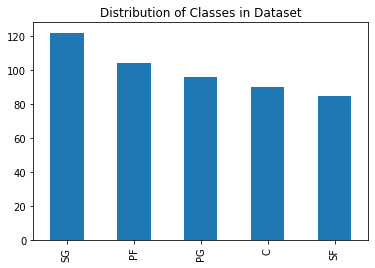

In [17]:
k =data["Pos"].value_counts().plot(kind='bar')
plt.title("Distribution of Classes in Dataset")

### Obtain Corelation between the Columns

Use the numpy column to get the correlation of values within the columns

In [20]:
dataCorr = data.iloc[:,3:].corr()
dataCorr.style.background_gradient(cmap='coolwarm').set_precision(2)

,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
G,1.00,0.58,0.66,0.52,0.51,0.34,0.44,0.43,0.29,0.45,0.43,0.33,0.34,0.35,0.36,0.43,0.34,0.49,0.48,0.34,0.51,0.24,0.34,0.52,0.51
GS,0.58,1.00,0.80,0.73,0.72,0.23,0.52,0.53,0.18,0.67,0.68,0.20,0.20,0.59,0.61,0.27,0.39,0.66,0.63,0.55,0.56,0.33,0.61,0.59,0.72
MP,0.66,0.80,1.00,0.88,0.89,0.31,0.70,0.72,0.31,0.78,0.79,0.31,0.30,0.70,0.70,0.43,0.39,0.75,0.70,0.71,0.75,0.36,0.73,0.73,0.88
FG,0.52,0.73,0.88,1.00,0.98,0.35,0.68,0.68,0.28,0.94,0.94,0.31,0.30,0.83,0.83,0.38,0.37,0.73,0.67,0.71,0.66,0.35,0.79,0.61,0.99
FGA,0.51,0.72,0.89,0.98,1.00,0.22,0.75,0.77,0.29,0.87,0.91,0.22,0.21,0.81,0.80,0.39,0.26,0.68,0.60,0.75,0.68,0.26,0.80,0.58,0.98
FG%,0.34,0.23,0.31,0.35,0.22,1.00,0.07,0.00,0.26,0.40,0.31,0.66,0.92,0.24,0.29,0.14,0.47,0.37,0.43,0.12,0.19,0.36,0.16,0.34,0.31
3P,0.44,0.52,0.70,0.68,0.75,0.07,1.00,0.98,0.52,0.38,0.42,0.09,0.25,0.48,0.42,0.42,-0.13,0.35,0.23,0.52,0.50,-0.00,0.49,0.35,0.73
3PA,0.43,0.53,0.72,0.68,0.77,0.00,0.98,1.00,0.45,0.39,0.45,0.10,0.16,0.49,0.44,0.41,-0.14,0.36,0.23,0.56,0.53,-0.01,0.53,0.37,0.73
3P%,0.29,0.18,0.31,0.28,0.29,0.26,0.52,0.45,1.00,0.10,0.13,-0.02,0.52,0.17,0.13,0.29,-0.17,0.10,0.03,0.22,0.23,-0.12,0.16,0.14,0.31
2P,0.45,0.67,0.78,0.94,0.87,0.40,0.38,0.39,0.10,1.00,0.98,0.34,0.26,0.82,0.85,0.27,0.53,0.75,0.74,0.65,0.59,0.44,0.76,0.60,0.90


In [21]:
# Select upper triangle of correlation matrix
upper = dataCorr.where(np.triu(np.ones(dataCorr.shape), k=1).astype(np.bool))

/tmp/ipykernel_717824/3270681497.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = dataCorr.where(np.triu(np.ones(dataCorr.shape), k=1).astype(np.bool))


### Feature Selection

We remove features which are highly corelated and we drop the non necessary Columns

In [27]:
## Find All the Columns which are Corelated more than 0.95
to_drop = [column for column in upper.columns  if any(upper[column] > 0.95)]

print("The columns to be dropped for corelation ")
print(to_drop)

The columns to be dropped for corelation 
['FGA', '3PA', '2PA', 'FTA', 'TRB', 'PTS']


In [28]:
data.drop(to_drop, axis=1, inplace=True)

#### Copy data to new Dataframe 

In [34]:
dataFinal = data.iloc[:,4:]

## Labeling non Numerical Data

In [46]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
Y = le.fit_transform(data["Pos"])
       
print(le.classes_)

['C' 'PF' 'PG' 'SF' 'SG']


## Test Train Data Split

In [50]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    dataFinal.to_numpy(), Y, test_size=0.30, random_state=42)

In [52]:
print("Percentage of Train :  " , X_train.shape[0]/dataFinal.shape[0])
print("Percentage of Test :  " , X_test.shape[0]/dataFinal.shape[0])

Percentage of Train :   0.6981891348088531
Percentage of Test :   0.30181086519114686


Text(0.5, 1.0, 'Test Train Split')

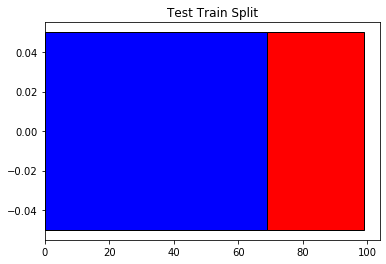

In [58]:
# y = ["test train Split"]
y=[0]

train = [int((X_train.shape[0]/dataFinal.shape[0])*100)]
test = [int((X_test.shape[0]/dataFinal.shape[0])*100)]

plt.barh(y, train,height=0.1, color='blue', edgecolor='black')
plt.barh(y, test,height=0.1, left=train, color='red', edgecolor='black')
plt.title("Test Train Split")

## Need for Scalling Model



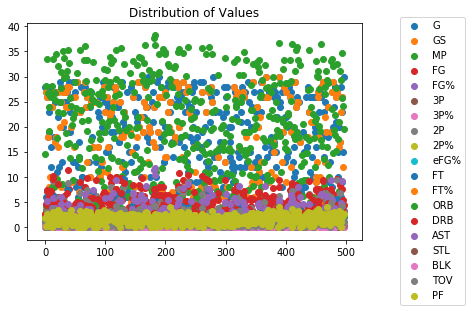

In [67]:
for col in dataFinal.columns:
    plt.scatter(np.linspace(0,dataFinal.shape[0]-1,dataFinal.shape[0]),dataFinal[col],label=col)

plt.title("Distribution of Values")
plt.legend(bbox_to_anchor=(1.1, 1.05))

### Visualisation after Scalling

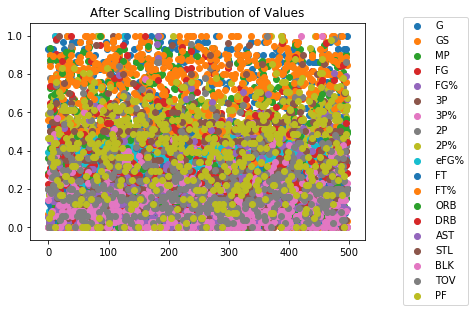

In [73]:
from sklearn.preprocessing import StandardScaler

dd = dataFinal.copy(deep=True)

dd = (dd-dd.min())/(dd.max()-dd.min())

for col in dd.columns:
    plt.scatter(np.linspace(0,dataFinal.shape[0]-1,dd.shape[0]),dd[col],label=col)

plt.title("After Scalling Distribution of Values")
plt.legend(bbox_to_anchor=(1.1, 1.05))

# Support Vector Classification (SVC)

Perform support vector Classificarion

In [168]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## geneerate SVM Model
SVCmodel = SVC(C=0.99, kernel='sigmoid',gamma='auto',tol=0.0001)


pipe = Pipeline([
    ("scale",StandardScaler()),
    ("model", SVCmodel)
])


#### Train the Model

In [169]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 SVC(C=0.99, gamma='auto', kernel='sigmoid', tol=0.0001))])

#### Perform Prediction using thr model

In [170]:
pred_y = pipe.predict(X_test)

## Q2 : Print Accuracy 
---


In [227]:
from sklearn.metrics import accuracy_score,f1_score

print("The Accuracy of the SVM Model is : ", str(accuracy_score(y_test,pred_y)).format(":.2f"))
print("The F1 score of the SVM Model is : ", str(f1_score(y_test,pred_y,average="macro")).format(":.2f"))

The Accuracy of the SVM Model is :  0.49333333333333335
The F1 score of the SVM Model is :  0.4811509084951108


## Confusion Matrix
---

It is a method for determining how well a machine learning classification algorithm performs when the output can include two or more classes.

In [177]:
print("Confusion matrix:")
print(pd.crosstab(y_test, pred_y, rownames=['True'], colnames=['Predicted'], margins=True))

Confusion matrix:
Predicted   0   1   2   3   4  All
True                              
0          18   9   2   0   0   29
1           5  14   1   0   8   28
2           0   2  20   3   7   32
3           3   8   4   5   6   26
4           1  10   5   2  17   35
All        27  43  32  10  38  150


<Figure size 2400x1800 with 0 Axes>

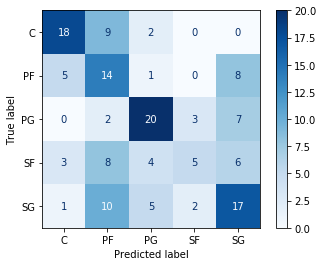

In [193]:
##using Sklearn 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred_y, labels=list(pipe["model"].classes_))

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(le.classes_))
plt.figure(figsize=(8,6),dpi=300)
disp.plot(cmap=plt.cm.Blues)

plt.show()

## Q3: Cross Validation
---



In [198]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(pipe,dataFinal , Y, cv=10)


Cross-validation scores: [0.34       0.34       0.5        0.42       0.5        0.36
 0.48       0.44897959 0.48979592 0.3877551 ]
Average cross-validation score: 0.43


## Q4: Printing CrossFold Acccuracy

In [199]:
print("Cross-validation scores: {}".format(scores))
print("Average cross-validation score: {:.2f}".format(scores.mean()))

Cross-validation scores: [0.34       0.34       0.5        0.42       0.5        0.36
 0.48       0.44897959 0.48979592 0.3877551 ]
Average cross-validation score: 0.43


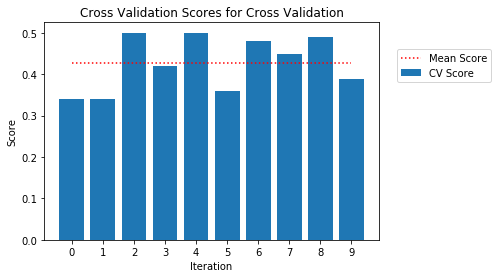

In [218]:
plt.bar(list(range(len(scores))) , scores,label="CV Score")
plt.title("Cross Validation Scores for Cross Validation")
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.xticks(list(range(len(scores))))

l = np.ones((len(scores),))

l = l*scores.mean()
plt.plot(list(range(len(scores))),l,':r',label="Mean Score")
plt.legend(bbox_to_anchor=(1.35,0.90))


plt.show()


In [221]:
from sklearn.metrics import classification_report
print("Classification Report: \n",classification_report(y_test, pred_y))

Classification Report: 
               precision    recall  f1-score   support

           0       0.67      0.62      0.64        29
           1       0.33      0.50      0.39        28
           2       0.62      0.62      0.62        32
           3       0.50      0.19      0.28        26
           4       0.45      0.49      0.47        35

    accuracy                           0.49       150
   macro avg       0.51      0.48      0.48       150
weighted avg       0.51      0.49      0.49       150

